TKO_3120 Machine Learning and Pattern Recognition

Image recognition exercise

Sam Student <br>
sam.student@utu.fi

January 2020

---


This is the template for the image recognition exercise. <Br>
Some **general instructions**:
 - write a clear *report*, understandable for an unspecialized reader: define shortly the concepts and explain the phases you use
    - use the Markdown feature of the notebook for larger explanations
 - return your output as a working Jupyter notebook
 - name your file as MLPR20_exercise_surname.jpynb
 - write easily readable code with comments     
     - if you exploit some code from web, provide a reference
     - avoid redundant code! Exploit the relevent parts and modify the code for your purposes to produce only what you need 
 - it is ok to discuss with a friend about the assignment. But it is not ok to copy someone's work. Everyone should submit their own implementation

**Deadline 13th of March at 16:00**
- No extension granted, unless you have an extremely justified reason. In such case, ask for extension well in advance!
- Start now, do not leave it to the last minute. This exercise will need some labour!
- If you encounter problems, Google first and if you can’t find an answer, ask for help
    - pekavir@utu.fi

**Grading**

The exercise covers a part of the grading in this course. The course exam has 5 questions, 6 points of each. Exercise gives 4 points, i.e. the total score is 34 points. Two extra points can be acquired by completing the bonus task. <br>

From the template below, you can see how many exercise points can be acquired from each task. Exam points are given according to the table below: <br>
<br>
7-8 exercise points: 1 point <br>
9-10 exercise points: 2 points <br>
11-12 exercise points: 3 points <br>
13-14 exercise points: 4 points <br>
<br>
To pass the exercise, you need at least 7 exercise points, distributed somewhat evenly into tasks (you can't just implement Introduction, Data preparation and Feature extraction and leave the left undone!) <Br>        

## Introduction

Write an introductory chapter for your report **(1 p)**
<br>E.g.
- What is the purpose of this task?
- What kind of data were used? Where did it originate?
- Which methods did you use?

Images: https://unsplash.com/

## Data preparation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io, transform, color

In [2]:
def show_img(img):
    plt.subplots(figsize=(8, 6))
    plt.imshow(img)

def resize_img(img, shape):
    return transform.resize(img, shape, preserve_range=True)

In [3]:
def img_channel_mean(img, channel_index):
    channel = img[:, :, channel_index]
    return np.mean(channel)

def img_r_mean(img):
    return img_channel_mean(img, 0)

def img_g_mean(img):
    return img_channel_mean(img, 1)

def img_b_mean(img):
    return img_channel_mean(img, 2)

def img_channel_variance(img, channel_index):
    channel = img[:, :, channel_index]
    return np.var(channel)

def img_r_variance(img):
    return img_channel_variance(img, 0)

def img_g_variance(img):
    return img_channel_variance(img, 1)

def img_b_variance(img):
    return img_channel_variance(img, 2) 

In [3]:
from skimage.feature import texture

def glcm_correlation(img, pixel_distances, angles=[0, np.pi / 2], levels=8):
    grayscaled = color.rgb2gray(img).astype(int)
    reduced = np.floor((grayscaled / 255) * levels).astype(int)
    glcms = texture.greycomatrix(reduced, pixel_distances, angles=angles, levels=levels, normed=True, symmetric=True)
    correlations = texture.greycoprops(glcms, 'correlation')
    return np.array([correlations[:, 0], correlations[:, 1]])

In [5]:
def preprocess_img(img):
    return resize_img(img, (300, 300))

def extract_features(img):
    correlations = glcm_correlation(img, [2, 3])
    horizontal_smoothness = correlations[:, 0]
    vertical_smoothness = correlations[:, 1]
    return (
        img_r_mean(img),
        img_g_mean(img),
        img_b_mean(img),
        img_r_variance(img),
        img_g_variance(img),
        img_b_variance(img),
        *horizontal_smoothness,
        *vertical_smoothness
    )

In [6]:
categories = [
    (0, 'sand.txt'), 
    (1, 'grass.txt'), 
    (2, 'stairs.txt')
]

input_array = []
for cat_id, cat_urls_file in categories:
    cat_urls = np.loadtxt(cat_urls_file, dtype='U150')
    
    for url in cat_urls:
        img = io.imread(url)
        preprocessed = preprocess_img(img)
        features = extract_features(preprocessed)
        
        input_array.append(
            [*features, cat_id]
        )

In [136]:
feature_index = [
    'R mean',  'G mean', 'B mean', 
    'R variance', 'G variance', 'B variance', 
    'Horizontal smoothness #1', 'Horizontal smoothness #2',
    'Vertical smoothness #1', 'Vertical smoothness #2',
    'Category'
]

data = pd.DataFrame(input_array, columns=feature_index)

features = data.drop('Category', axis=1, inplace=False)
categories = data['Category'].astype(int)

In [137]:
features.head()

,R mean,G mean,B mean,R variance,G variance,B variance,Horizontal smoothness #1,Horizontal smoothness #2,Vertical smoothness #1,Vertical smoothness #2
0,194.776410,165.387687,142.901508,563.559045,597.253541,507.250026,0.602046,0.607513,0.582189,0.592732
1,203.179267,177.127218,141.848734,162.902561,150.384857,125.779320,0.683536,0.168246,0.600512,-0.013596
2,209.286086,153.585664,127.026846,1664.624177,2394.619500,2224.736896,0.973603,0.907315,0.965525,0.853929
3,178.151341,127.762167,82.454480,663.540706,486.874587,362.943892,0.527914,0.515529,0.482018,0.473186
4,204.377670,185.428245,176.172585,3466.546247,3284.625045,4088.892210,0.961862,0.945046,0.951476,0.927518


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standartized = scaler.fit_transform(features)

features = pd.DataFrame(standartized, columns=features.columns)
features.head()

,R mean,G mean,B mean,R variance,G variance,B variance,Horizontal smoothness #1,Horizontal smoothness #2,Vertical smoothness #1,Vertical smoothness #2
0,1.455948,1.010815,0.885207,-1.046247,-1.015690,-0.798879,-1.393938,-1.153666,-1.136227,-0.834876
1,1.628542,1.301463,0.863814,-1.280732,-1.309825,-0.954126,-0.900349,-3.678757,-1.037291,-3.917267
2,1.753977,0.718619,0.562632,-0.401846,0.167360,-0.099911,0.856591,0.569717,0.933590,0.492969
3,1.114468,0.079278,-0.343082,-0.987732,-1.088343,-0.857607,-1.842957,-1.682430,-1.677097,-1.442613
4,1.653158,1.506981,1.561278,0.652732,0.753173,0.658747,0.785481,0.786612,0.857733,0.867073


Text(0, 0.5, 'Second principal component')

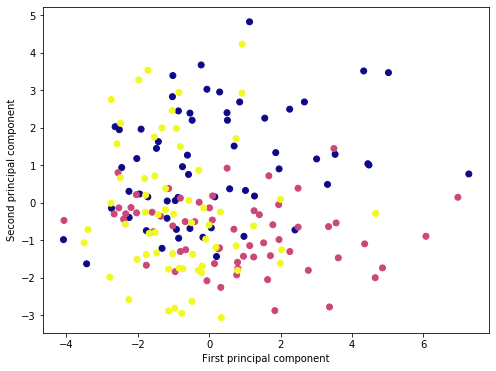

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=categories, cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

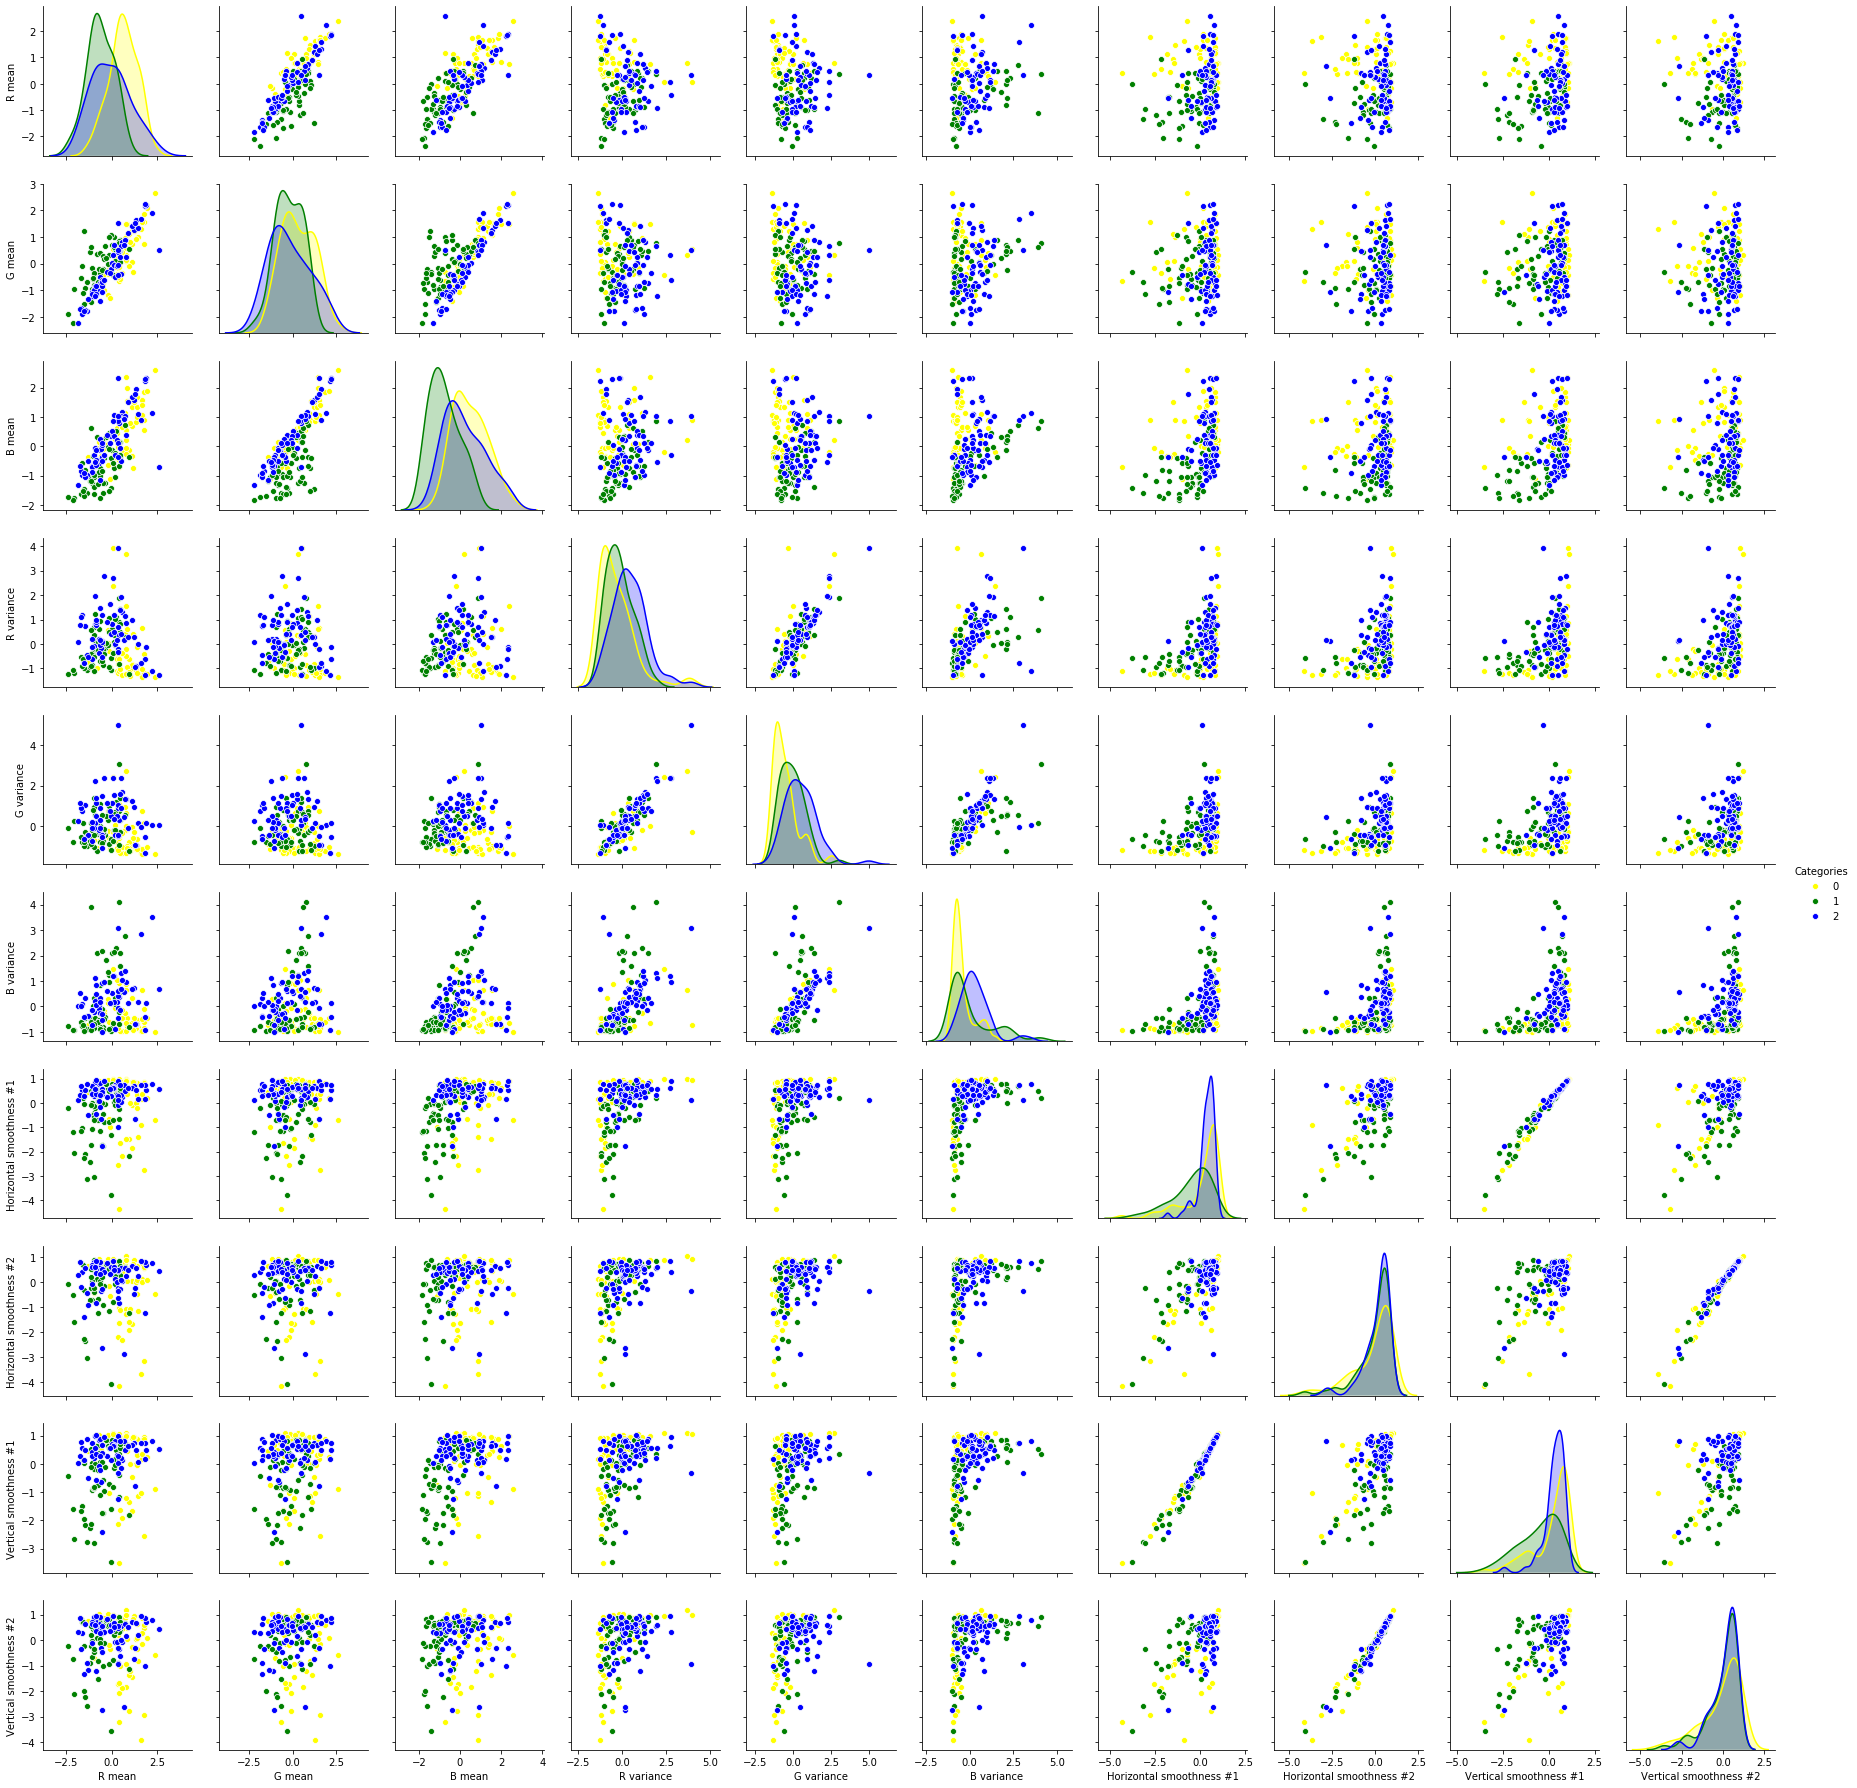

In [11]:
import seaborn as sns

pp_features = features.copy()
pp_features['Categories'] = categories

variables = pp_features.columns[pp_features.columns != 'Categories']

sns.pairplot(pp_features, hue='Categories', vars=variables, palette={
    0: 'yellow',
    1: 'green',
    2: 'blue'
})

In [100]:
# Nested leave one out cross validation
from collections import namedtuple
from time import time

from sklearn.model_selection import LeaveOneOut
from tqdm.notebook import tqdm

NestedCVResult = namedtuple('NestedCVResult', [
    'best_params', 'y_preds', 'time_took'
])

def nested_cv(params_to_try, classifier_factory, X, Y):
    try:
        X, Y = X.to_numpy(), Y.to_numpy()
    except AttributeError:
        pass
    
    loo = LeaveOneOut()

    best_params = []
    y_preds = []

    start_time = time()
    for train_indices, test_indices in tqdm(loo.split(X), total=X.shape[0]):
        X_train, X_test = X[train_indices], X[test_indices]
        Y_train, Y_test = Y[train_indices], Y[test_indices]

        print(X_train.shape, Y_train.shape)
        
        scores = []
        for param in params_to_try:
            inner_scores = []
            for subtrain_indices, subtest_indices in loo.split(X_train):
                X_subtrain, X_subtest = X_train[subtrain_indices], X_train[subtest_indices]
                Y_subtrain, Y_subtest = Y_train[subtrain_indices], Y_train[subtest_indices]

                classifier = classifier_factory(param)
                classifier.fit(X_subtrain, Y_subtrain)
                
                inner_scores.append(classifier.score(X_subtest, Y_subtest))
            scores.append(np.mean(inner_scores))

        best_param = params_to_try[scores.index(max(scores))]    
        best_params.append(best_param)

        classifier = classifier_factory(best_param)
        classifier.fit(X_train, Y_train)

        y_preds.append(classifier.predict(X_test))
        
    return NestedCVResult(best_params, y_preds, time() - start_time)

In [102]:
from sklearn.neighbors import KNeighborsClassifier

results = nested_cv(
    range(1, 10),
    lambda k: KNeighborsClassifier(n_neighbors=k),
    features,
    categories
)

In [15]:
from sklearn.metrics import confusion_matrix

def build_confusion_matrix(y_truth, y_preds):
    return pd.DataFrame(
        confusion_matrix(categories, y_preds), 
        ['T: grass', 'T: sand', 'T: stairs'], 
        ['P: grass', 'P: sand', 'P: stairs']
    )

build_confusion_matrix(categories, results.y_preds)

,P: grass,P: sand,P: stairs
T: grass,51,3,7
T: sand,7,42,13
T: stairs,16,11,35


In [16]:
from sklearn import metrics

def accuracy_score(y_truth, y_preds):
    return np.round(metrics.accuracy_score(y_truth, y_preds), 3)

print(f'Accuracy score: {accuracy_score(categories, results.y_preds)}')

Accuracy score: 0.692


In [20]:
import datetime

def format_seconds(seconds):
    return datetime.timedelta(seconds=int(seconds))

In [21]:
best_ks = results.best_params

print('Best K counts:')
for k in np.unique(best_ks):
    print(f'K = {k}, best {best_ks.count(k)} times')
    
print(f'\nTraining took: {format_seconds(results.time_took)}')

Best K counts:
K = 4, best 23 times
K = 5, best 136 times
K = 6, best 4 times
K = 7, best 22 times

Training took: 0:05:20


### Ridge

In [22]:
from sklearn.linear_model import RidgeClassifier

results = nested_cv(
    np.arange(0.0, 5, 0.5),
    lambda alpha: RidgeClassifier(alpha),
    features,
    categories
)

build_confusion_matrix(categories, results.y_preds)

,P: grass,P: sand,P: stairs
T: grass,50,0,11
T: sand,4,52,6
T: stairs,16,3,43


In [23]:
print(f'Accuracy score: {accuracy_score(categories, results.y_preds)}')

Accuracy score: 0.784


In [24]:
best_alphas = results.best_params

print('Best Alpha counts:')
for alpha in np.unique(best_alphas):
    print(f'Alpha = {alpha}, best {best_alphas.count(alpha)} times')
    
print(f'\nTraining took: {format_seconds(results.time_took)}')

# Note: because alpha = 0 is the most commont param it means that we could change Ridge to Linear regression

Best Alpha counts:
Alpha = 0.0, best 88 times
Alpha = 0.5, best 78 times
Alpha = 1.0, best 14 times
Alpha = 1.5, best 3 times
Alpha = 2.0, best 1 times
Alpha = 4.5, best 1 times

Training took: 0:06:36


### Multi Layer Perceptron

- Multi-layer perceptron MLP **(2 p)**
    - optimize the number of neurons in the hidden layer and select the best model for the classifier
    - use Early stop committee, i.e. after selecting the model, calculate the prediction for the test data several times with different sampling of the training data. The members of the committee vote for the predicted class of the test sample. Use 50% of the training data for validation (algorithm terminates the training when validation score is not improving)
    - estimate the performance of the classifier with nested cross validation
    - calculate the accuracy and the confusion matrix


In [37]:
from sklearn.neural_network import MLPClassifier

results = nested_cv(
    [1],
    lambda n_neurons: MLPClassifier(hidden_layer_sizes=(n_neurons), activation='relu', solver='adam', early_stopping=True),
    features,
    categories
)

print(f'Accuracy score: {accuracy_score(categories, results.y_preds)}')
print(f'\nTraining took: {format_seconds(results.time_took)}')


Accuracy score: 0.335

Training took: 0:06:00


In [36]:
results = nested_cv(
    [2],
    lambda n_neurons: MLPClassifier(hidden_layer_sizes=(n_neurons), activation='relu', solver='adam', early_stopping=True),
    features,
    categories
)

print(f'Accuracy score: {accuracy_score(categories, results.y_preds)}')
print(f'\nTraining took: {format_seconds(results.time_took)}')


Accuracy score: 0.341

Training took: 0:06:00


In [38]:
results = nested_cv(
    [5],
    lambda n_neurons: MLPClassifier(hidden_layer_sizes=(n_neurons), activation='relu', solver='adam', early_stopping=True),
    features,
    categories
)

print(f'Accuracy score: {accuracy_score(categories, results.y_preds)}')
print(f'\nTraining took: {format_seconds(results.time_took)}')


Accuracy score: 0.384

Training took: 0:06:24


In [39]:
results = nested_cv(
    [10],
    lambda n_neurons: MLPClassifier(hidden_layer_sizes=(n_neurons), activation='relu', solver='adam', early_stopping=True),
    features,
    categories
)

print(f'Accuracy score: {accuracy_score(categories, results.y_preds)}')
print(f'\nTraining took: {format_seconds(results.time_took)}')


Accuracy score: 0.346

Training took: 0:07:31


In [40]:
results = nested_cv(
    [20],
    lambda n_neurons: MLPClassifier(hidden_layer_sizes=(n_neurons), activation='relu', solver='adam', early_stopping=True),
    features,
    categories
)

print(f'Accuracy score: {accuracy_score(categories, results.y_preds)}')
print(f'\nTraining took: {format_seconds(results.time_took)}')


Accuracy score: 0.416

Training took: 0:09:46


In [42]:
results = nested_cv(
    [50],
    lambda n_neurons: MLPClassifier(hidden_layer_sizes=(n_neurons), activation='relu', solver='adam', early_stopping=True),
    features,
    categories
)

print(f'Accuracy score: {accuracy_score(categories, results.y_preds)}')
print(f'\nTraining took: {format_seconds(results.time_took)}')


Accuracy score: 0.362

Training took: 0:19:21


In [43]:
results = nested_cv(
    [100],
    lambda n_neurons: MLPClassifier(hidden_layer_sizes=(n_neurons), activation='relu', solver='adam', early_stopping=True),
    features,
    categories
)

print(f'Accuracy score: {accuracy_score(categories, results.y_preds)}')
print(f'\nTraining took: {format_seconds(results.time_took)}')


Accuracy score: 0.497

Training took: 0:18:46


In [44]:
results = nested_cv(
    [120, 150, 200, 500],
    lambda n_neurons: MLPClassifier(hidden_layer_sizes=(n_neurons), activation='relu', solver='adam', early_stopping=True),
    features,
    categories
)

print(f'Accuracy score: {accuracy_score(categories, results.y_preds)}')
print(f'\nTraining took: {format_seconds(results.time_took)}')


Accuracy score: 0.627

Training took: 1:28:57


In [52]:
results = nested_cv(
    [750, 1000],
    lambda n_neurons: MLPClassifier(hidden_layer_sizes=(n_neurons), activation='relu', solver='adam', early_stopping=True),
    features,
    categories
)

print(f'Accuracy score: {accuracy_score(categories, results.y_preds)}')
print(f'\nTraining took: {format_seconds(results.time_took)}')


Accuracy score: 0.649

Training took: 2:13:22


In [53]:
print(f'Accuracy score: {accuracy_score(categories, results.y_preds)}')

best_neurons = results.best_params
print('Best Alpha counts:')
for n in np.unique(best_neurons):
    print(f'N = {n}, best {best_neurons.count(n)} times')
    
print(f'\nTraining took: {format_seconds(results.time_took)}')

Accuracy score: 0.649
Best Alpha counts:
N = 750, best 74 times
N = 1000, best 111 times

Training took: 2:13:22


1. Issirenku geriausia neuronu skaiciu n*
2. Sukuriu 5 MLP su n*
3. Padalinu savo seta per puse i Tr ir Te
4. Tr padalinu random i 5 dalis ir jomis apmokau MLP
5. Paimu Te praleidziu per visus 5MLP ir isrenku kategorija, kuria sake daugiausiai MLP
6. Ta kategorija dedu i y_pred seta

In [202]:
best_neuron_count = 1000
committee_size = 3

In [203]:
committee = [
    MLPClassifier(hidden_layer_sizes=(best_neuron_count), activation='relu', solver='adam', early_stopping=True)
    for _ in range(committee_size)
]

In [204]:
from sklearn.model_selection import train_test_split

data_set = features.copy()
data_set['Categories'] = categories

train_set, test_set = train_test_split(data_set.to_numpy(), train_size=0.5)

for i, split in enumerate(np.array_split(train_set, committee_size)):
    X_train, y_train = split[:, :-1], split[:, -1]
    committee[i].fit(X_train, y_train)

In [205]:
X_test, y_test = test_set[:, :-1], test_set[:, -1]

y_preds = []
for feats in X_test:
    feats = feats.reshape(1, -1)
    
    comittee_predictions = []
    for mlp in committee:
        comittee_predictions.append(mlp.predict(feats)[0])

    (values, counts) = np.unique(comittee_predictions, return_counts=True)
    y_preds.append(values[np.argmax(counts)])
    
print(y_preds)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0]


In [206]:
print(f'Accuracy score: {accuracy_score(y_test, y_preds)}')

Accuracy score: 0.462


Perform preparations for the data **(3 p)**
- import all the packages needed for this notebook in one cell
- read the URL:s from the text files and import the images
- crop and/or resize the images into same size
- for GLCM and GLRLM, change the images into grayscale and reduce the quantization level, e.g. to 8 levels

## Feature extraction

### First order texture measures (6 features)

- Calculate the below mentioned color features for each image **(1 p)**
    - Mean for each RGB color channel
    - Variance for each RGB color channel

### Second order texture measures (4 or 10 features)

- Gray-Level-Co-Occurrence (GLCM) features (4 features) **(2 p)**
    - For each image
        - calculate the GLC matrix
        - calculate the "correlation" feature using the GLC matrix that you acquired 
            - in horizontal and vertical directions for two reference pixel distances (you can choose the distances)
        - explain your choise for the distances<br>
<br>
- Gray-Level-Run-Length (GLRL) features (6 features) **(BONUS)**
    - Make an own implementation for Gray-Level-Run-Length (GLRL) matrix in
        - horizontal direction
        - vertical direction
        - test that your code works with the toy image: [[1,1,1,0],[2,0,0,1],[1,0,2,2],[0,0,0,0]]
    - Implement the following run-length features using the GLRL matrix that you acquired
        - Short-Run emphasis
        - Long-run emphasis
        - Run percentage
    - Include the resulting features in the input array X

Gather your features into an input array X, and the image classes into an output array y. Standardize the feature values in X.

## Feature relationships

Make illustrations of the feature relationships, and discuss the results

### Pairplot

- Pairplot **(1 p)**
    - Which feature pairs possess roughly linear dependence?

### PCA

- PCA **(1 p)**
    - Can you see any clusters in PCA?
    - Does this figure give you any clues, how well you will be able to classify the image types? Explain.

## Build classifiers and estimate their performance

### kNN

- k Nearest Neighbors classifier **(1 p)**
    - optimize the hyperparameter (k) and select the best model for the classifier
    - estimate the performance of the model with nested cross validation
    - calculate the accuracy and the confusion matrix

### Ridge regression

- Regularized linear model with Ridge regression **(1 p)**
    - optimize the hyperparameter (alpha) and select the best model for the classifier
    - estimate the performance of the model with nested cross validation
    - calculate the accuracy and the confusion matrix

 ### Multi-layer perceptron


- Multi-layer perceptron MLP **(2 p)**
    - build the classifier. Use:
        - 1 hidden layer
        - solver for weight optimization: stochastic gradient-based optimizer ('adam')
        - activation function for the hidden layer: rectified linear unit function ('relu')
        - Early stop
    - optimize the number of neurons in the hidden layer and select the best model for the classifier
    - use Early stop committee, i.e. after selecting the model, calculate the prediction for the test data several times with different sampling of the training data. The members of the committee vote for the predicted class of the test sample. Use 50% of the training data for validation (algorithm terminates the training when validation score is not improving)
    - estimate the performance of the classifier with nested cross validation
    - calculate the accuracy and the confusion matrix


## Discussion

- Discuss you results **(1 p)**
<br>E.g.
    - Which model performs the best and why?
    - What are the limitations?
    - How could the results be improved?